HRM Training Process

load sudoku data

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import os
import pydantic 

from typing import Optional

from dataset.sudoku import SudokuDataset

from typing import Tuple, List, Dict, Optional

import dataset.sudoku as sudoku

def load_sudoku_data(data_path: str, max_samples: int = 2000):
    # Load the dictionary that was saved
    data = np.load(data_path, allow_pickle=True).item()
 
    puzzles = []
    solutions = []

    # Extract puzzles and solutions from the dictionary
    for i in range(min(max_samples, len(data))):
        if i in data:
            puzzles.append(data[i]["puzzle"])
            solutions.append(data[i]["solution"])

    return np.array(puzzles), np.array(solutions)

# presenting the data
puzzles, solutions = load_sudoku_data("./data/sudoku_train.npy")
test_puzzles, test_solutions = load_sudoku_data("./data/sudoku_test.npy")

print(test_puzzles.shape)
print(test_solutions.shape)

sudoku.display_puzzle_pair(puzzles[0].reshape(9, 9), solutions[0].reshape(9, 9))

(2000, 81)
(2000, 81)

INPUT (_ = blank)        SOLUTION
  0 1 2 3 4 5 6 7 8      0 1 2 3 4 5 6 7 8
  -----------------      -----------------
0| _ _ 9 5 1 _ 7 3 _    0| 2 6 9 5 1 4 7 3 8
1| _ _ _ 2 _ 3 _ 5 _    1| 1 7 4 2 8 3 6 5 9
2| _ 3 _ _ 9 _ _ _ 2    2| 8 3 5 7 9 6 4 1 2
3| 3 1 _ _ _ _ _ _ _    3| 3 1 8 9 7 2 5 4 6
4| _ _ _ _ _ _ 2 _ _    4| 6 5 7 3 4 8 2 9 1
5| 4 _ _ _ _ _ _ _ _    5| 4 9 2 6 5 1 8 7 3
6| _ _ _ 8 6 _ _ _ 5    6| 9 4 3 8 6 7 1 2 5
7| _ _ _ 4 2 _ 3 6 _    7| 5 8 1 4 2 9 3 6 7
8| 7 _ _ _ _ _ _ 8 4    8| 7 2 6 1 3 5 9 8 4

Statistics: 25 filled, 56 blank cells


In [ ]:
from hrm import HRMTrainer, HRMConfig, HierarchicalReasoningModel, ModelConfig

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

hrm_config = HRMConfig(
    input_dim=1,   # Each position has 1 feature (digit value) - input is (B, 81, 1)
    output_dim=10, # 10 possible values (0-9) for each position
    hidden_dim=256, 
    num_layers=8,
    dropout=0.1,
    N=6,  
    T=12   
)

model_config = ModelConfig(
    learning_rate=5e-4,
    batch_size=64,
    max_epochs=50,
    embeddings_lr=0.002,
    weight_decay=1e-4  
)

model = HierarchicalReasoningModel(config=hrm_config, device=device)
#model = torch.compile(model)

trainer = HRMTrainer(model, config=model_config, device=device)

train_dataset = sudoku.SudokuDataset(puzzles, solutions)
val_dataset = sudoku.SudokuDataset(test_puzzles, test_solutions)

trainer.train(train_dataset, val_dataset=val_dataset)

Epoch 001 | Train Loss 4.4425 Acc 0.1193 | Val Loss 4.4425 Acc 0.1193 | LR 5.00e-04
Epoch 002 | Train Loss 2.4142 Acc 0.1100 | Val Loss 2.4001 Acc 0.1111 | LR 5.00e-04
Epoch 003 | Train Loss 2.4040 Acc 0.1104 | Val Loss 2.4040 Acc 0.1104 | LR 5.00e-04
Epoch 004 | Train Loss 2.4043 Acc 0.1120 | Val Loss 2.4052 Acc 0.1111 | LR 5.00e-04
Epoch 005 | Train Loss 2.4023 Acc 0.1112 | Val Loss 2.4023 Acc 0.1112 | LR 5.00e-04
Best model (val_loss=2.4001) saved to results/best_model.pt


In [3]:
def validate_sudoku_predictions(model, dataset, num_samples=10):
    
    model.eval()
    
    def is_valid_sudoku(grid):
        
        for row in grid:
            if len(set(row)) != 9 or not all(1 <= x <= 9 for x in row):
                return False
        
        # Check columns
        for col in range(9):
            column = [grid[row][col] for row in range(9)]
            if len(set(column)) != 9:
                return False
        
        # Check 3x3 boxes
        for box_row in range(3):
            for box_col in range(3):
                box = []
                for r in range(3):
                    for c in range(3):
                        box.append(grid[box_row*3 + r][box_col*3 + c])
                if len(set(box)) != 9:
                    return False
        
        return True
    
    def calculate_cell_accuracy(predicted, target):
        return (predicted == target).float().mean().item()
    
    # Sample validation data
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    results = {
        'valid_sudokus': 0,
        'total_samples': 0,
        'cell_accuracies': [],
        'sudoku_validity_rate': 0.0,
        'average_cell_accuracy': 0.0
    }
    
    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= num_samples:
                break
                
            puzzle, solution = batch["puzzle"], batch["solution"]
            puzzle = puzzle.to(device)#.float()
            solution = solution.to(device).long()
            
            # Get model prediction
            #if puzzle.dim() == 2:
            #    puzzle = puzzle.unsqueeze(-1)  # Add feature dimension
            
            output = model(puzzle)  # Shape: (1, 81, 10)
            predicted = output.argmax(dim=-1)  # Shape: (1, 81)
            
            # Convert to numpy and reshape to 9x9
            pred_grid = predicted.cpu().numpy()[0].reshape(9, 9)
            true_grid = solution.cpu().numpy()[0].reshape(9, 9)
            
            # Calculate cell accuracy
            cell_acc = calculate_cell_accuracy(predicted[0], solution[0])
            results['cell_accuracies'].append(cell_acc)
            
            # Check if prediction is valid sudoku
            is_valid = is_valid_sudoku(pred_grid)
            if is_valid:
                results['valid_sudokus'] += 1
            
            results['total_samples'] += 1
            
            # Print first few examples
            if i < 1:
                print(f"\nSample {i+1}:")
                print("Puzzle:")
                puzzle_display = puzzle.cpu().numpy()[0].reshape(9, 9)
                for row in puzzle_display:
                    print([int(x) for x in row])
                
                print("Predicted Solution:")
                for row in pred_grid:
                    print(list(row))
                
                print("True Solution:")
                for row in true_grid:
                    print(list(row))
                
                print(f"Cell Accuracy: {cell_acc:.4f}")
                print(f"Valid Sudoku: {is_valid}")
    
    # Calculate final metrics
    results['sudoku_validity_rate'] = results['valid_sudokus'] / results['total_samples']
    results['average_cell_accuracy'] = sum(results['cell_accuracies']) / len(results['cell_accuracies'])
    
    print(f"\n=== Sudoku Validation Results ===")
    print(f"Total samples validated: {results['total_samples']}")
    print(f"Valid Sudoku solutions: {results['valid_sudokus']}")
    print(f"Sudoku validity rate: {results['sudoku_validity_rate']:.4f} ({results['sudoku_validity_rate']*100:.2f}%)")
    print(f"Average cell accuracy: {results['average_cell_accuracy']:.4f} ({results['average_cell_accuracy']*100:.2f}%)")
    
    return results

# Run validation
validation_results = validate_sudoku_predictions(model, val_dataset, num_samples=10)


Sample 1:
Puzzle:
[0, 0, 3, 0, 0, 0, 0, 9, 0]
[9, 8, 2, 0, 0, 4, 0, 0, 7]
[0, 0, 0, 2, 0, 9, 0, 0, 0]
[0, 0, 0, 0, 6, 2, 0, 0, 0]
[0, 0, 7, 0, 9, 3, 5, 6, 2]
[0, 9, 0, 0, 4, 0, 0, 7, 3]
[0, 0, 4, 0, 0, 0, 0, 2, 0]
[8, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 6, 0, 0, 0]
Predicted Solution:
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
[

Loaded best model from epoch 2 with val_loss 2.4001

=== Comprehensive Model Evaluation on 1000 Test Games ===
Eval Loss 2.3987 Acc 0.1111

Sample 1:
Puzzle:
[8, 0, 0, 0, 2, 0, 0, 0, 4]
[0, 0, 9, 0, 8, 1, 0, 0, 0]
[0, 0, 4, 0, 3, 0, 0, 0, 0]
[0, 0, 0, 5, 7, 0, 0, 0, 0]
[0, 4, 0, 0, 9, 8, 6, 0, 0]
[0, 0, 5, 6, 4, 2, 0, 0, 0]
[0, 3, 0, 0, 0, 4, 5, 0, 0]
[0, 0, 8, 0, 6, 0, 0, 4, 0]
[0, 0, 2, 0, 0, 0, 0, 0, 0]
Predicted Solution:
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int

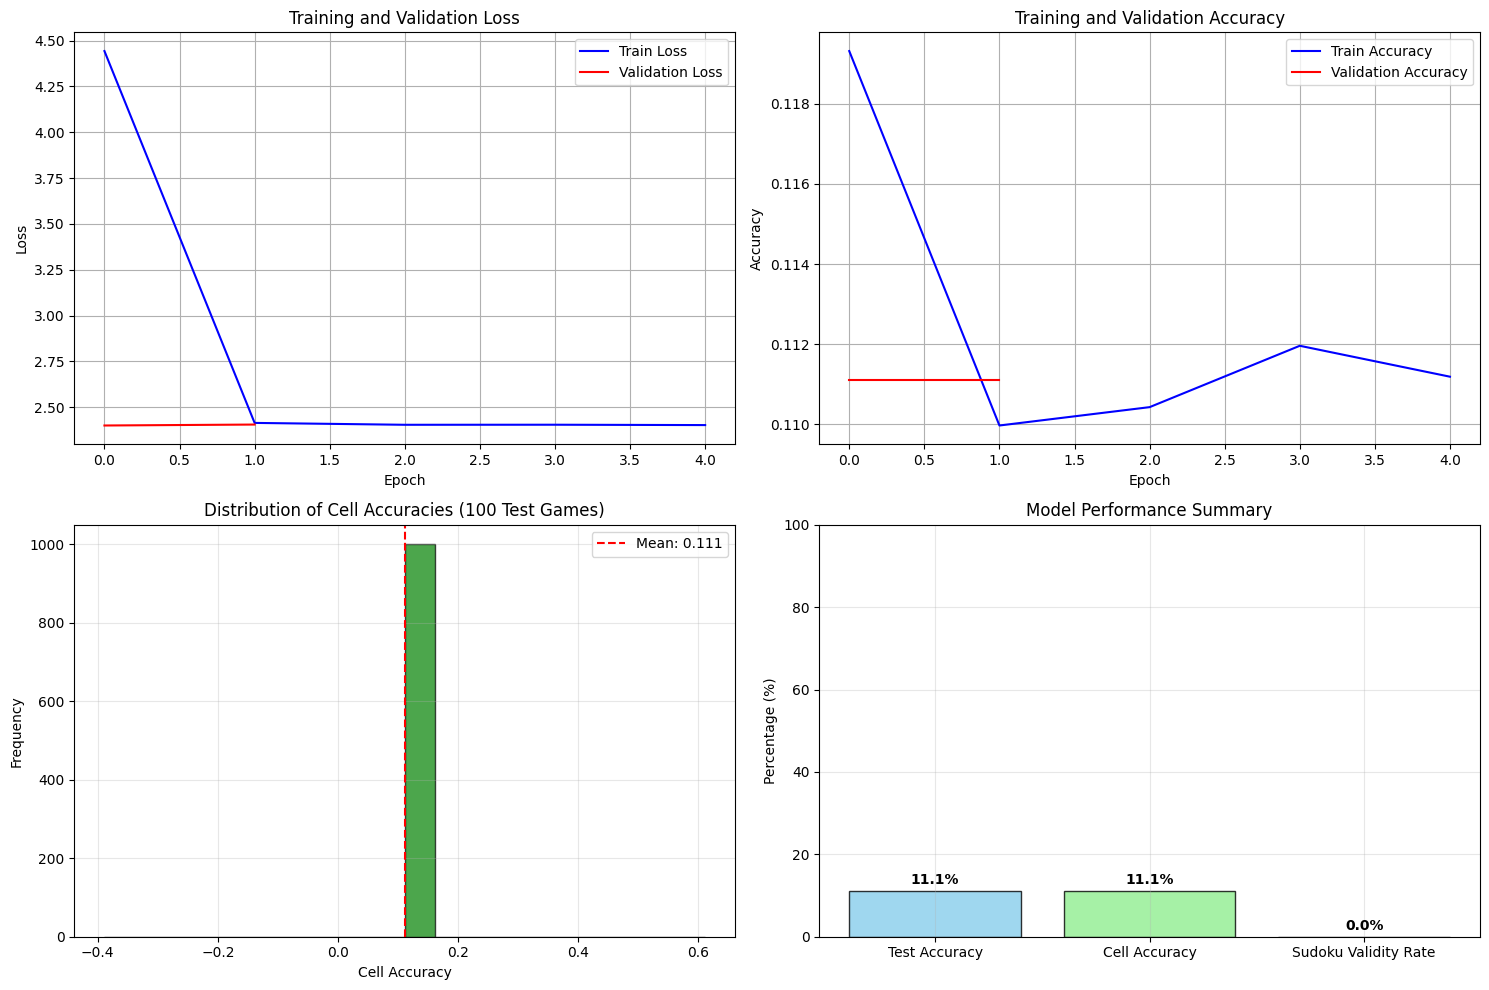

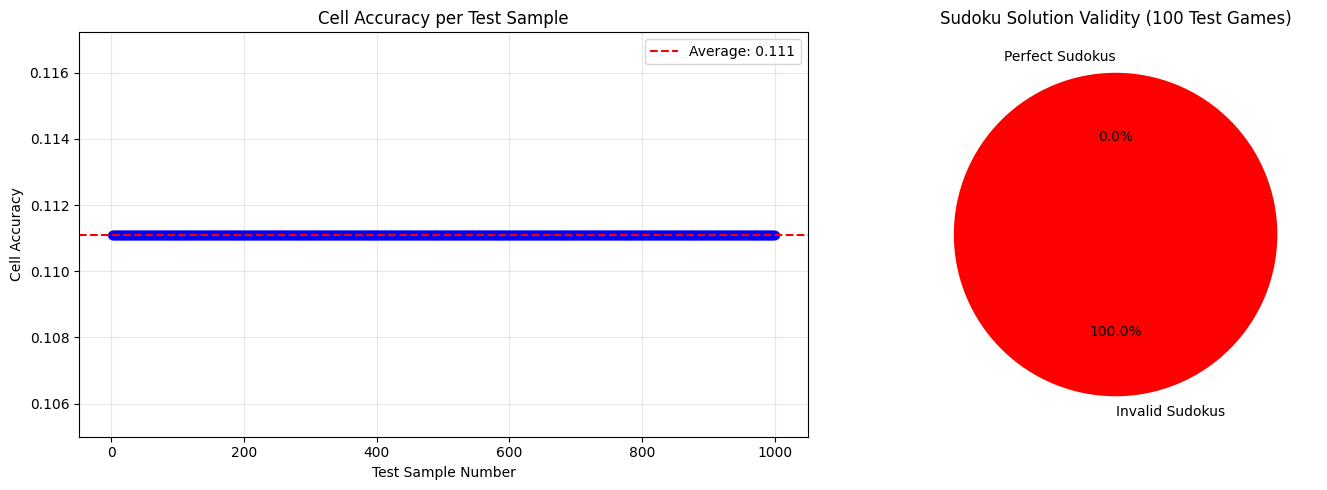


Graphs saved to 'results/model_evaluation_results.png' and 'results/detailed_accuracy_analysis.png'


In [4]:
# Load the best model and evaluate on 100 test samples
best_checkpoint = torch.load('results/best_model.pt', map_location=device)
#model.load_state_dict(best_checkpoint['model'])
print(f"Loaded best model from epoch {best_checkpoint['epoch']} with val_loss {best_checkpoint['val_loss']:.4f}")

total_games = 1000  
# Create a subset of test dataset with 100 samples
test_subset_puzzles = test_puzzles[:total_games]
test_subset_solutions = test_solutions[:total_games]
test_subset_dataset = sudoku.SudokuDataset(test_subset_puzzles, test_subset_solutions)

# Comprehensive evaluation
print(f"\n=== Comprehensive Model Evaluation on {total_games} Test Games ===")

# 1. Basic accuracy evaluation using trainer
test_loss, test_acc = trainer.evaluate(test_subset_dataset)

# 2. Detailed Sudoku validation
detailed_results = validate_sudoku_predictions(model, test_subset_dataset, num_samples=1000)

# 3. Summary statistics
print(f"\n=== Final Results Summary ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Valid Sudoku Solutions: {detailed_results['valid_sudokus']}/100 ({detailed_results['sudoku_validity_rate']*100:.2f}%)")
print(f"Average Cell Accuracy: {detailed_results['average_cell_accuracy']:.4f} ({detailed_results['average_cell_accuracy']*100:.2f}%)")

# 4. Visualizations
import matplotlib.pyplot as plt

# Create a comprehensive results visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Training curves
ax1.plot(trainer.train_losses, label='Train Loss', color='blue')
ax1.plot(trainer.val_losses, label='Validation Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(trainer.train_accuracies, label='Train Accuracy', color='blue')
ax2.plot(trainer.val_accuracies, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Cell accuracy distribution
ax3.hist(detailed_results['cell_accuracies'], bins=20, alpha=0.7, color='green', edgecolor='black')
ax3.set_xlabel('Cell Accuracy')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Cell Accuracies (100 Test Games)')
ax3.axvline(detailed_results['average_cell_accuracy'], color='red', linestyle='--', 
           label=f'Mean: {detailed_results["average_cell_accuracy"]:.3f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Summary metrics bar chart
metrics = ['Test Accuracy', 'Cell Accuracy', 'Sudoku Validity Rate']
values = [test_acc * 100, detailed_results['average_cell_accuracy'] * 100, 
          detailed_results['sudoku_validity_rate'] * 100]
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = ax4.bar(metrics, values, color=colors, edgecolor='black', alpha=0.8)
ax4.set_ylabel('Percentage (%)')
ax4.set_title('Model Performance Summary')
ax4.set_ylim(0, 100)

# Add value labels on bars
for bar, value in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/model_evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed accuracy analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Cell accuracy vs sample number
sample_numbers = range(1, len(detailed_results['cell_accuracies']) + 1)
ax1.plot(sample_numbers, detailed_results['cell_accuracies'], 'o-', alpha=0.7, color='blue')
ax1.axhline(detailed_results['average_cell_accuracy'], color='red', linestyle='--', 
           label=f'Average: {detailed_results["average_cell_accuracy"]:.3f}')
ax1.set_xlabel('Test Sample Number')
ax1.set_ylabel('Cell Accuracy')
ax1.set_title('Cell Accuracy per Test Sample')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Performance comparison chart
categories = ['Perfect Sudokus', 'Invalid Sudokus']
counts = [detailed_results['valid_sudokus'], 100 - detailed_results['valid_sudokus']]
colors = ['green', 'red']

ax2.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title(f'Sudoku Solution Validity ({sum(counts)} Test Games)')

plt.tight_layout()
plt.savefig('results/detailed_accuracy_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGraphs saved to 'results/model_evaluation_results.png' and 'results/detailed_accuracy_analysis.png'")